In [11]:
import requests
from bs4 import BeautifulSoup
import time

In [12]:
def fetch_wiki_data(url: str) -> BeautifulSoup:
  response = requests.get(url, headers={"User-Agent": "KRR-Assignment-Agent"})
  if response.status_code == 200:
    time.sleep(1)
    return BeautifulSoup(response.content, 'html.parser')
  else:
    raise Exception(f"Failed to fetch data: {response.status_code}")

URL = "https://en.wikipedia.org/wiki/List_of_mayors_of_New_York_City#Post-consolidation_mayors_(since_1897)"
soup = fetch_wiki_data(URL)

In [13]:
import re

def get_mayors_from_2000_to_2025(soup: BeautifulSoup) -> list:
  table = soup.find_all('table', {'class': 'wikitable'})
  post_consolidation_table = table[2]
  mayors = []

  def extract_date(s: str):
    if s == 'Incumbent':
      return ('January', 1, 2024)
    rgx = r'([a-zA-Z]+)\s([0-9]{1,2}),\s([0-9]{4})'
    match = re.search(rgx, s)
    if match:
      return (match.group(1), int(match.group(2)), int(match.group(3)))
    return (None, 0, 0)
  
  def clean_name(name: str) -> str:
    name = re.sub(r'\(.*?\)', '', name)
    name = name.replace('\xa0', ' ')
    return name.strip()
  
  for i, row in enumerate(post_consolidation_table.find_all('tr')[1:]):
    cols = row.find_all('td')
    from_term, to_term = cols[2].get_text(strip=True).split('–')

    if extract_date(to_term)[2] < 2000 or extract_date(from_term)[2] > 2025:
      continue

    name = cols[1].get_text(strip=True)

    mayors.append({
      'mayor_no': 91 + i,
      'name': clean_name(name),
      'from': from_term,
      'to': to_term
    })
  
  return mayors

mayors = get_mayors_from_2000_to_2025(soup)

mayors

[{'mayor_no': 110,
  'name': 'Rudy Giuliani',
  'from': 'January 1, 1994',
  'to': 'December 31, 2001'},
 {'mayor_no': 111,
  'name': 'Michael Bloomberg',
  'from': 'January 1, 2002',
  'to': 'December 31, 2013'},
 {'mayor_no': 112,
  'name': 'Bill de Blasio',
  'from': 'January 1, 2014',
  'to': 'December 31, 2021'},
 {'mayor_no': 113,
  'name': 'Eric Adams',
  'from': 'January 1, 2022',
  'to': 'Incumbent'}]

In [14]:
def get_extended_mayor_info(mayor: dict) -> dict:
  name = mayor['name']
  search_name = name.replace(' ', '_')
  wiki_url = f"https://en.wikipedia.org/wiki/{search_name}"
  mayor_soup = fetch_wiki_data(wiki_url)

  infobox = mayor_soup.find('table', {'class': 'infobox'})
  all_rows = infobox.find_all('tr')

  def get_infobox_value(label: str) -> str:
    row = infobox.find('th', string=re.compile(label))
    if not row:
      return None
    value_cell = row.find_next_sibling('td')
    if value_cell:
      return value_cell.get_text(strip=True)
  
  def get_infobox_at_index(index: int) -> str:
    value_cell = all_rows[index].find('td')
    if value_cell:
      return value_cell.get_text(strip=True)
  
  def clean_party(party: str) -> str:
    if not party:
      return None
    if 'Republican' in party:
      return 'Republican'
    elif 'Democratic' in party:
      return 'Democratic'
    elif 'Independent' in party:
      return 'Independent'
    return party

  mayor['party'] = clean_party(get_infobox_value('Political party'))

  if mayor['name'] == 'Michael Bloomberg':
    mayor['preceded_by'] = get_infobox_at_index(6)
    mayor['succeeded_by'] = get_infobox_at_index(7)
  elif mayor['name'] == 'Eric Adams':
    mayor['preceded_by'] = get_infobox_at_index(6)
    mayor['succeeded_by'] = None
  else:
    mayor['preceded_by'] = get_infobox_at_index(5)
    mayor['succeeded_by'] = get_infobox_at_index(6)
  
  return mayor

for i, mayor in enumerate(mayors):
  mayors[i] = get_extended_mayor_info(mayor)
mayors

[{'mayor_no': 110,
  'name': 'Rudy Giuliani',
  'from': 'January 1, 1994',
  'to': 'December 31, 2001',
  'party': 'Republican',
  'preceded_by': 'David Dinkins',
  'succeeded_by': 'Michael Bloomberg'},
 {'mayor_no': 111,
  'name': 'Michael Bloomberg',
  'from': 'January 1, 2002',
  'to': 'December 31, 2013',
  'party': 'Republican',
  'preceded_by': 'Rudy Giuliani',
  'succeeded_by': 'Bill de Blasio'},
 {'mayor_no': 112,
  'name': 'Bill de Blasio',
  'from': 'January 1, 2014',
  'to': 'December 31, 2021',
  'party': 'Democratic',
  'preceded_by': 'Michael Bloomberg',
  'succeeded_by': 'Eric Adams'},
 {'mayor_no': 113,
  'name': 'Eric Adams',
  'from': 'January 1, 2022',
  'to': 'Incumbent',
  'party': 'Democratic',
  'preceded_by': 'Bill de Blasio',
  'succeeded_by': None}]

In [15]:
from rdflib import Graph, Namespace, Literal, URIRef
from rdflib.namespace import RDF, RDFS, XSD, FOAF

g = Graph()

NYC = Namespace("http://example.org/nyc/")
MAYOR = Namespace("http://example.org/nyc/mayor/")
SCHEMA = Namespace("http://schema.org/")

g.bind("nyc", NYC)
g.bind("mayor", MAYOR)
g.bind("schema", SCHEMA)
g.bind("foaf", FOAF)

for mayor in mayors:
  mayor_uri = MAYOR[f"mayor_{mayor['mayor_no']}"]
  
  g.add((mayor_uri, RDF.type, NYC.Mayor))
  g.add((mayor_uri, NYC.mayorNumber, Literal(mayor['mayor_no'], datatype=XSD.integer)))
  g.add((mayor_uri, FOAF.name, Literal(mayor['name'])))
  g.add((mayor_uri, NYC.termStart, Literal(mayor['from'])))
  g.add((mayor_uri, NYC.termEnd, Literal(mayor['to'])))
  g.add((mayor_uri, NYC.politicalParty, Literal(mayor['party'])))
  
  if mayor.get('preceded_by'):
    for pred_mayor in mayors:
      if pred_mayor['name'] == mayor['preceded_by']:
        pred_uri = MAYOR[f"mayor_{pred_mayor['mayor_no']}"]
        g.add((mayor_uri, NYC.precededBy, pred_uri))
        break
  
  if mayor.get('succeeded_by'):
    for succ_mayor in mayors:
      if succ_mayor['name'] == mayor['succeeded_by']:
        succ_uri = MAYOR[f"mayor_{succ_mayor['mayor_no']}"]
        g.add((mayor_uri, NYC.succeededBy, succ_uri))
        break

In [16]:
print(g.serialize(format='turtle'))
g.serialize(destination='mayors_kg.ttl', format='turtle')

@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix mayor: <http://example.org/nyc/mayor/> .
@prefix nyc: <http://example.org/nyc/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

mayor:mayor_110 a nyc:Mayor ;
    nyc:mayorNumber 110 ;
    nyc:politicalParty "Republican" ;
    nyc:succeededBy mayor:mayor_111 ;
    nyc:termEnd "December 31, 2001" ;
    nyc:termStart "January 1, 1994" ;
    foaf:name "Rudy Giuliani" .

mayor:mayor_113 a nyc:Mayor ;
    nyc:mayorNumber 113 ;
    nyc:politicalParty "Democratic" ;
    nyc:precededBy mayor:mayor_112 ;
    nyc:termEnd "Incumbent" ;
    nyc:termStart "January 1, 2022" ;
    foaf:name "Eric Adams" .

mayor:mayor_111 a nyc:Mayor ;
    nyc:mayorNumber 111 ;
    nyc:politicalParty "Republican" ;
    nyc:precededBy mayor:mayor_110 ;
    nyc:succeededBy mayor:mayor_112 ;
    nyc:termEnd "December 31, 2013" ;
    nyc:termStart "January 1, 2002" ;
    foaf:name "Michael Bloomberg" .

mayor:mayor_112 a nyc:Mayor ;
    nyc:mayorNumber 112 ;
    n

<Graph identifier=Ne6d03498720a4c56a52e016c7b89a6b7 (<class 'rdflib.graph.Graph'>)>

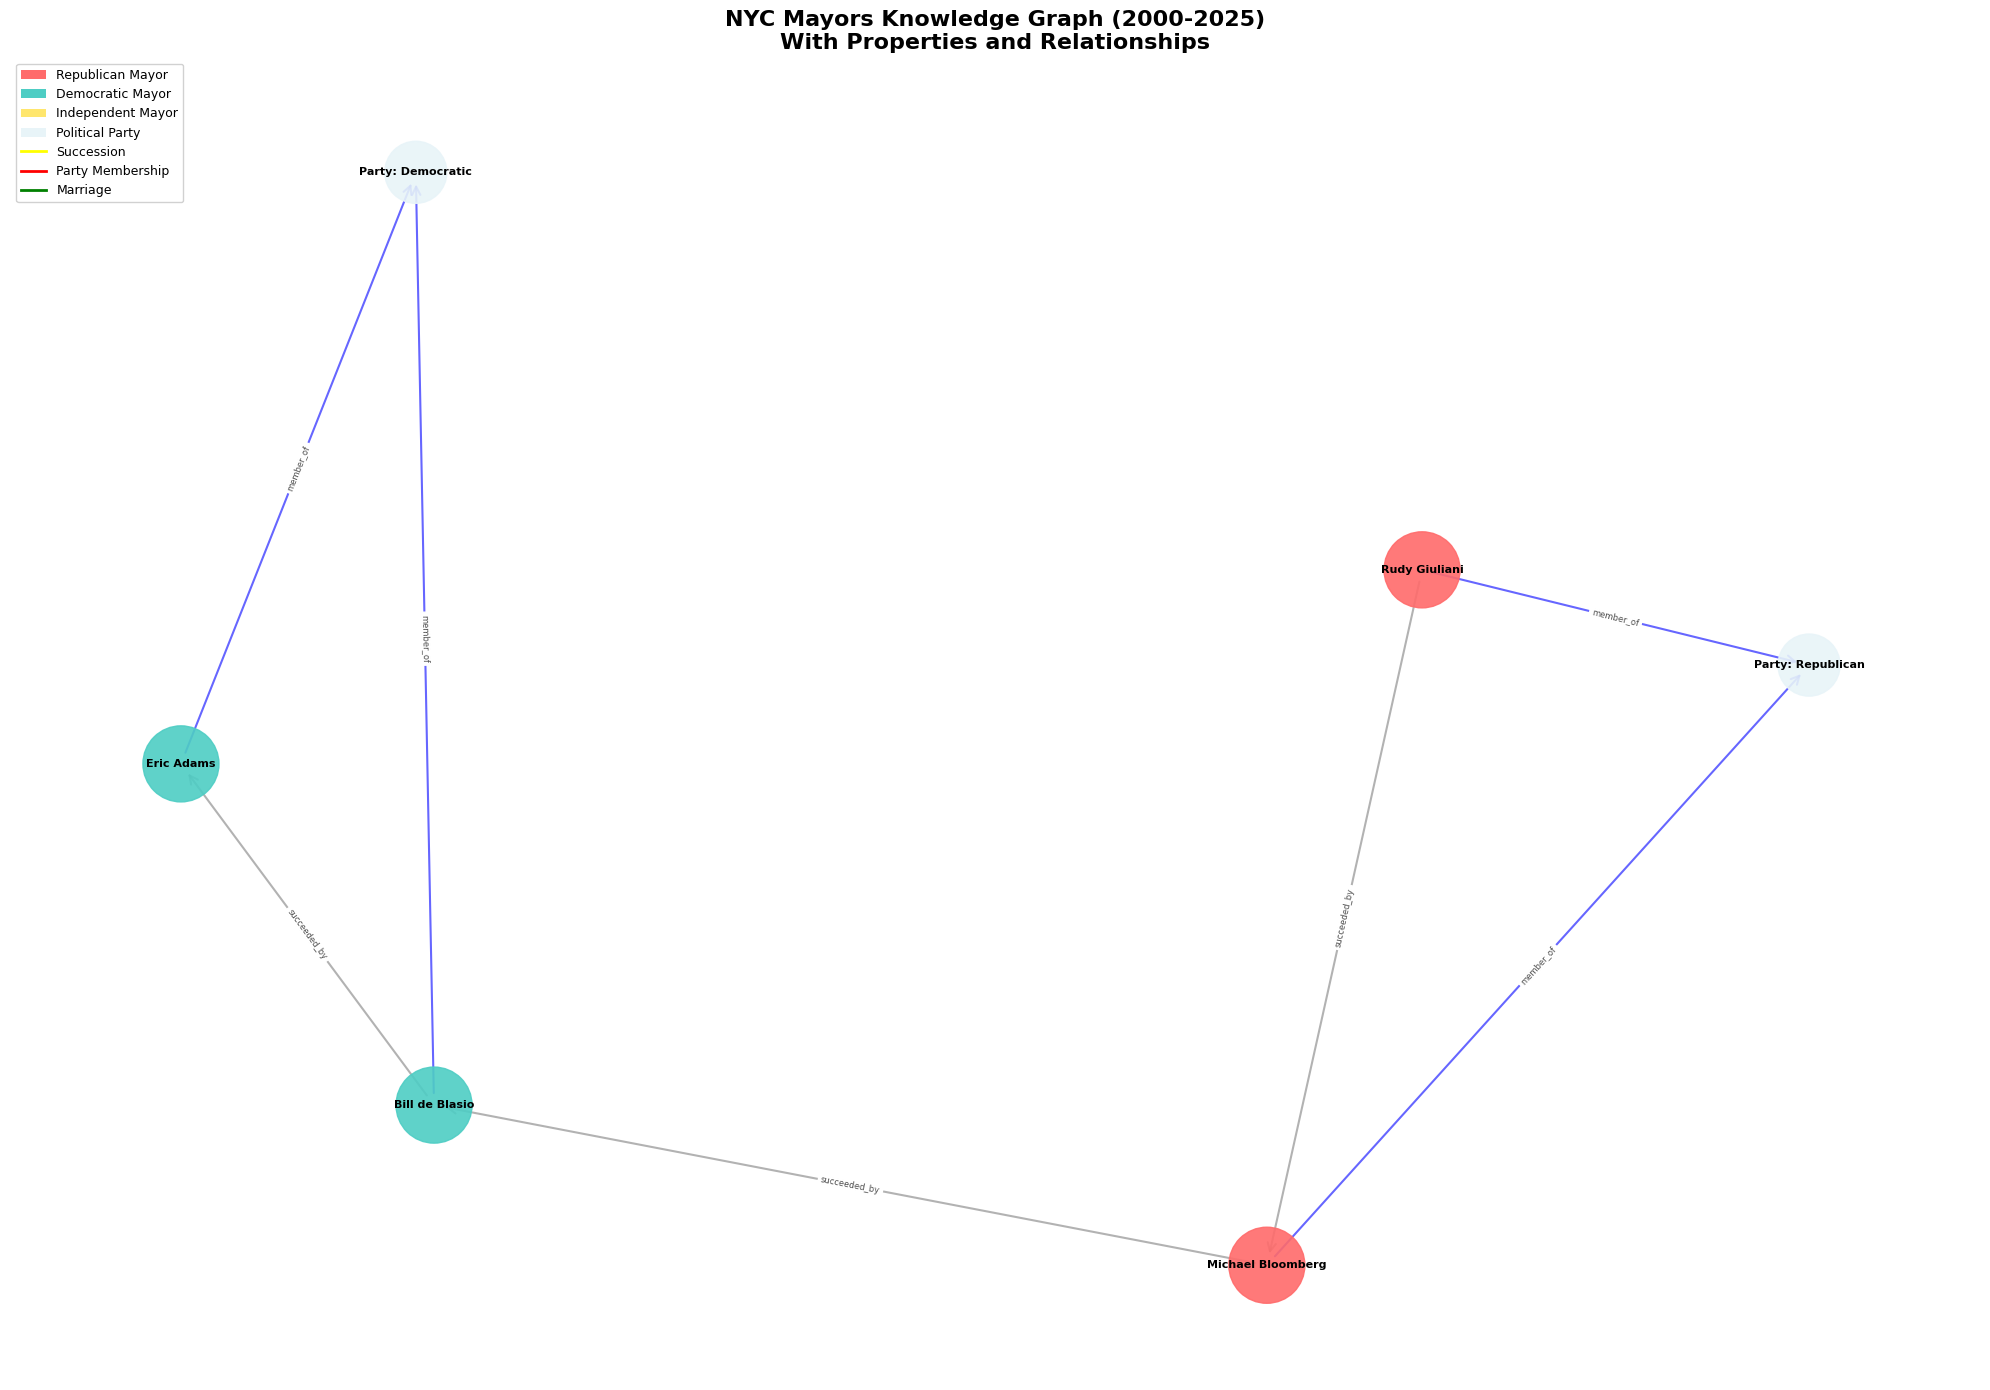

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.MultiDiGraph()

for mayor in mayors:
  mayor_name = mayor['name']
  G.add_node(
    mayor_name,
    party=mayor.get('party', 'Unknown'),
    term=f"{mayor['from']} - {mayor['to']}"
  )

parties = set()

for mayor in mayors:
  if mayor.get('party'):
    parties.add(mayor['party'])

for party in parties:
  G.add_node(f"Party: {party}", node_type='party')

for mayor in mayors:
  mayor_name = mayor['name']
  
  if mayor.get('succeeded_by') and mayor['succeeded_by'] != 'Incumbent':
    for other in mayors:
      if other['name'] == mayor['succeeded_by']:
        G.add_edge(mayor_name, mayor['succeeded_by'], label='succeeded_by', edge_type='succession')
        break
  
  if mayor.get('party'):
    G.add_edge(mayor_name, f"Party: {mayor['party']}", label='member_of', edge_type='party')
  
plt.figure(figsize=(20, 14))
pos = nx.spring_layout(G, k=3, iterations=100, seed=42)

node_colors = []
node_sizes = []
for node in G.nodes():
  node_data = G.nodes[node]
  node_type = node_data.get('node_type', 'mayor')
  
  if node_type == 'mayor':
    party = node_data.get('party', 'Unknown')
    party_colors = {
      'Republican': '#FF6B6B',
      'Democratic': '#4ECDC4',
      'Independent': '#FFE66D'
    }
    node_colors.append(party_colors.get(party, '#95A5A6'))
    node_sizes.append(3000)
  elif node_type == 'party':
    node_colors.append('#E8F4F8')
    node_sizes.append(2000)

nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

edge_colors = {'succession': 'gray', 'party': 'blue'}
for edge_type, color in edge_colors.items():
  edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('edge_type') == edge_type]
  nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=color, arrows=True, arrowsize=15, arrowstyle='->', width=1.5, alpha=0.6)

edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6, alpha=0.7)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
  Patch(facecolor='#FF6B6B', label='Republican Mayor'),
  Patch(facecolor='#4ECDC4', label='Democratic Mayor'),
  Patch(facecolor='#FFE66D', label='Independent Mayor'),
  Patch(facecolor='#E8F4F8', label='Political Party'),
  Line2D([0], [0], color='yellow', lw=2, label='Succession'),
  Line2D([0], [0], color='red', lw=2, label='Party Membership'),
  Line2D([0], [0], color='green', lw=2, label='Marriage'),
]
plt.legend(handles=legend_elements, loc='upper left', fontsize=9, framealpha=0.9)

plt.title('NYC Mayors Knowledge Graph (2000-2025)\nWith Properties and Relationships', fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('mayors_knowledge_graph.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
query1 = """
PREFIX nyc: <http://example.org/nyc/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

SELECT ?leader1 ?leader2 ?leader3 ?leader4
WHERE {
  ?person1 foaf:name "Rudy Giuliani" ;
          nyc:succeededBy ?person2 .
  ?person2 foaf:name ?leader2 ;
          nyc:succeededBy ?person3 .
  ?person3 foaf:name ?leader3 ;
          nyc:succeededBy ?person4 .
  ?person4 foaf:name ?leader4 .
  ?person1 foaf:name ?leader1 .
}
"""
results1 = g.query(query1)
for row in results1:
    print(f"Succession chain: {row.leader1} → {row.leader2} → {row.leader3} → {row.leader4}")

print("\n=== Query 2: Political Party Distribution ===")
query2 = """
PREFIX nyc: <http://example.org/nyc/>

SELECT ?politicalParty (COUNT(?official) AS ?totalCount)
WHERE {
  ?official a nyc:Mayor ;
         nyc:politicalParty ?politicalParty .
}
GROUP BY ?politicalParty
ORDER BY DESC(?totalCount)
"""
results2 = g.query(query2)
for row in results2:
    print(f"{row.politicalParty}: {row.totalCount} mayors")

print("\n=== Query 3: Mayor Details ===")
query3 = """
PREFIX nyc: <http://example.org/nyc/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX schema: <http://schema.org/>

SELECT ?fullName ?affiliation ?born ?partner
WHERE {
  ?official a nyc:Mayor ;
         foaf:name ?fullName ;
         nyc:politicalParty ?affiliation ;
         schema:birthDate ?born .
  OPTIONAL { ?official schema:spouse ?partner . }
}
"""
results3 = g.query(query3)
for row in results3:
    partner_info = row.partner if row.partner else "No data"
    print(f"Name: {row.fullName}, Party: {row.affiliation}, Born: {row.born}, Spouse: {partner_info}")

print("\n=== Query 4: Republican Mayors After #110 ===")
query4 = """
PREFIX nyc: <http://example.org/nyc/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

SELECT ?fullName ?officialNumber ?politicalAffiliation
WHERE {
  ?official a nyc:Mayor ;
         foaf:name ?fullName ;
         nyc:mayorNumber ?officialNumber ;
         nyc:politicalParty ?politicalAffiliation .
  FILTER (?officialNumber > 110 && ?politicalAffiliation = "Republican")
}
"""
results4 = g.query(query4)
for row in results4:
    print(f"Name: {row.fullName}, Mayor #: {row.officialNumber}, Party: {row.politicalAffiliation}")

print("\n=== Query 5: All Mayors' Terms ===")
query5 = """
PREFIX nyc: <http://example.org/nyc/>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>

SELECT ?fullName ?startDate ?endDate
WHERE {
  ?official a nyc:Mayor ;
         foaf:name ?fullName ;
         nyc:termStart ?startDate ;
         nyc:termEnd ?endDate .
}
"""
results5 = g.query(query5)
for row in results5:
    print(f"Mayor: {row.fullName}, Term: {row.startDate} to {row.endDate}")

Succession chain: Rudy Giuliani → Michael Bloomberg → Bill de Blasio → Eric Adams

=== Query 2: Political Party Distribution ===
Republican: 2 mayors
Democratic: 2 mayors

=== Query 3: Mayor Details ===

=== Query 4: Republican Mayors After #110 ===
Name: Michael Bloomberg, Mayor #: 111, Party: Republican

=== Query 5: All Mayors' Terms ===
Mayor: Rudy Giuliani, Term: January 1, 1994 to December 31, 2001
Mayor: Michael Bloomberg, Term: January 1, 2002 to December 31, 2013
Mayor: Bill de Blasio, Term: January 1, 2014 to December 31, 2021
Mayor: Eric Adams, Term: January 1, 2022 to Incumbent
